In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Levenshtein
from itertools import product
import math
import re
from statsmodels.base.covtype import descriptions
import copy

In [101]:
data = pd.read_csv("ml_insurance_challenge.csv")
labels = pd.read_csv("insurance_taxonomy - insurance_taxonomy.csv")

 We build the word list for each label.

In [102]:
label_words = []
for label in labels['label']:
    label = re.sub(r"[,\'\[\].\-&()-/]", "", label)
    label = label.replace("and", "")
    label = label.replace("with", "")
    label = label.replace("of", "")
    label_words.append(label.lower().split()[::-1])

In [103]:
print(label_words[:100])

[['services', 'equipment', 'agricultural'], ['services', 'application', 'nutrient', 'soil'], ['services', 'application', 'pesticide'], ['nurseries', 'plant', 'ornamental'], ['services', 'lscaping'], ['services', 'gardening'], ['removal', 'pruning', 'services', 'tree'], ['services', 'veterinary'], ['clinics', 'veterinary'], ['services', 'boarding', 'pet'], ['services', 'care', 'day', 'animal'], ['services', 'grooming', 'pet'], ['services', 'training', 'animal'], ['centers', 'health', 'veterinary'], ['trainers', 'animal'], ['services', 'dealer', 'livestock'], ['operations', 'harvesting', 'timber'], ['services', 'hunting', 'fishing'], ['services', 'maintenance', 'well'], ['services', 'welding', 'field'], ['mining', 'gravel', 's'], ['construction', 'driveway', 'residential'], ['construction', 'driveway', 'commercial'], ['services', 'construction', 'fencing'], ['services', 'construction', 'sidewalk'], ['systems', 'irrigation', 'commercial'], ['systems', 'drainage', 'residential'], ['removal

We add weight to the words from the description.

In [104]:
def put_weigths(i : int, tag : str, weight : float):
    if not pd.isna(data.loc[i, tag]):
        line = data.loc[i, tag]
        line = re.sub(r"[,\'\[\].\-&()-/]", "", line)
        dw = len(line.split()) * [weight] 
        return line.lower().split(), dw
    else:
        return [], []

In [105]:
data_words = []
data_weights = []

for i in range(len(data)):
    business_tags, dw2 = put_weigths(i, "business_tags", 0)
    category, dw3 = put_weigths(i, "category", 0)
    niche, dw4 = put_weigths(i, "niche", 0)
    sector, dw5 = put_weigths(i, "sector", 0)
    description, dw1 = put_weigths(i, "description", 0.25)

    line = description + business_tags + category + niche + sector
    dw = dw1 + dw2 + dw3 + dw4 + dw5
    data_words.append(line)
    data_weights.append(dw)
    
    if len(dw) != len(line):
        print("Problema la dw !")

We also include the character position in the distance calculation, to account for prefixes and penalize errors. A sum of such positions is related to the square of the word length.

In [107]:
def _distance_(word_1 : str, word_2 : str):
    distance = 0
    word = word_1 if len(word_1) > len(word_2) else word_2
    sec_word = word_1 if len(word_1) <= len(word_2) else word_2
    l1 = len(word)
    l2 = len(sec_word)
    for idx, c1 in enumerate(word):
        if idx > l2 - 1 or c1 != sec_word[idx]:
            distance += l1 - idx 
    return 10 * distance / l1 ** 2        

In [108]:
def get_distance(index : int, point: list[str]) -> float:
    distance = 1
    for coord in point:
        l = len(coord)
        min_distance1d = min(_distance_(coord, word) + weight
        for word, weight in zip(data_words[index], data_weights[index]))
        distance += min_distance1d 
    return distance

In [109]:
distances = []

for index in range(len(data_words)):
    distances.append(np.array([get_distance(index, point) for point in label_words]))

distances = np.array(distances)

The EM algorithm, where we want the learning to be smoother and the steps smaller, because computationally, matrix operations are efficient, so we focus on accuracy.

In [110]:
def initialize_probabilities(n_points, n_clusters):
    probabilities = np.random.rand(n_points, n_clusters)
    probabilities /= probabilities.sum(axis=1, keepdims=True)
    return probabilities

def expectation_step(distances, probabilities, tau=2.0):
    exp_weights = np.exp(-distances / tau)
    probabilities = exp_weights / exp_weights.sum(axis=1, keepdims=True) + 1e-10
    return probabilities

def maximization_step(distances, probabilities):
    new_centroids = (probabilities.T @ distances) / probabilities.sum(axis=0, keepdims=True).T
    return new_centroids

def em_clustering(distances, n_clusters, max_iters=100, tol=1e-8, alpha=0.8):
    n_points = distances.shape[0]
    probabilities = initialize_probabilities(n_points, n_clusters)
    
    error = []
    
    for iteration in range(max_iters):
        old_probabilities = probabilities.copy()

        new_probabilities = expectation_step(distances, probabilities, tau=2.0)
         
        probabilities = alpha * old_probabilities + (1 - alpha) * new_probabilities
         
        centroids = maximization_step(distances, probabilities)
        
        if np.linalg.norm(probabilities - old_probabilities) < tol:
            print(f"S-a oprit la {iteration + 1}")
            break
        
        error.append(np.linalg.norm(probabilities - old_probabilities))
    
    return probabilities, error


np.random.seed(42)
n_points, n_clusters = len(data_words), len(label_words)
final_probabilities, error = em_clustering(distances, n_clusters)


S-a oprit la 87


In [111]:
top_indices = np.argsort(final_probabilities[3])[-10:][::-1]

print(data_words[3])
for idx in top_indices:
    print(f"Valoare: {final_probabilities[3][idx]}, Label: {label_words[idx]}")

['patagonia', 'chapa', 'y', 'pintura', 'is', 'an', 'auto', 'body', 'shop', 'located', 'in', 'comodoro', 'rivadavia', 'chubut', 'province', 'argentina', 'the', 'company', 'specializes', 'in', 'providing', 'auto', 'body', 'repair', 'services', 'automotive', 'body', 'repair', 'services', 'interior', 'repair', 'services', 'auto', 'body', 'shops', 'automotive', 'body', 'paint', 'and', 'interior', 'repair', 'and', 'maintenance', 'services']
Valoare: 0.058972084416558546, Label: ['services', 'painting']
Valoare: 0.03413042408293082, Label: ['services', 'printing']
Valoare: 0.029102212100674808, Label: ['services', 'compliance']
Valoare: 0.026999387709452923, Label: ['services', 'arts']
Valoare: 0.02382687604281644, Label: ['services', 'seo']
Valoare: 0.023498234750105793, Label: ['services', 'repair', 'boiler']
Valoare: 0.02309380014844845, Label: ['services', 'catering']
Valoare: 0.022784058509539788, Label: ['services', 'insurance']
Valoare: 0.02210522905494779, Label: ['services', 'veterin

We check for the probability distribution condition.

In [125]:
print(np.sum(final_probabilities[0]))

1.0000000219999998


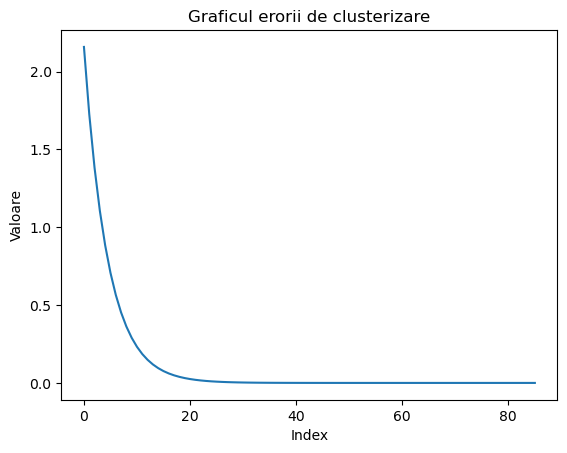

In [113]:
plt.plot(error, linestyle='-')
plt.title("Graficul erorii de clusterizare")
plt.xlabel("Index")
plt.ylabel("Valoare")
plt.show()

In this graph, we display the maximum probabilities ordered in ascending order and observe that the method distinguishes features, as it is much better than a random choice.

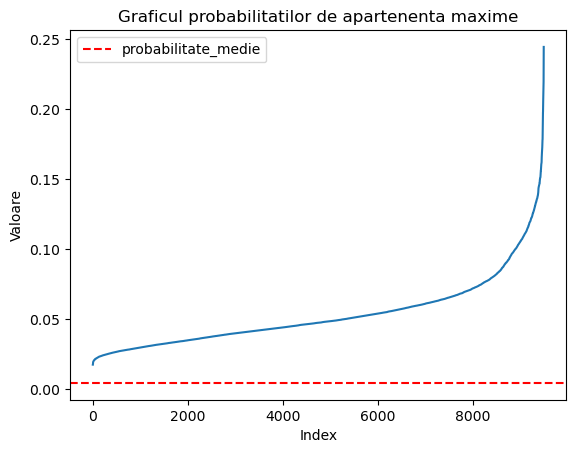

In [114]:
max_prob = [np.max(final_probabilities[i]) for i in range(len(final_probabilities))]
plt.plot(np.sort(max_prob))
plt.title("Graficul probabilitatilor de apartenenta maxime")
plt.axhline(y=1 / len(label_words), color='r', linestyle='--', label = "probabilitate_medie")
plt.xlabel("Index")
plt.ylabel("Valoare")
plt.legend()
plt.show()

In [115]:
 def check_difference(line : list[str], label : list[str]):
     
    diff = 0
    for word in label:
        diff += min(Levenshtein.distance(word, x) for x in line)
    
    return diff

In [116]:
top_indices = [np.argmax(final_probabilities[i]) for i in range(len(final_probabilities))]
differences = [check_difference(data_words[i], label_words[top_indices[i]]) for i in range(len(data_words))]

In [117]:
nr_char = 0
nr_word = 0
for line in label_words:
    for word in line:
        nr_char += len(word)
    nr_word += len(line)

medium_lengh_word_label = nr_char / nr_word

In [118]:
print(medium_lengh_word_label)

8.165853658536586


We check with the Levenshtein distance the difference between the business data and solutions. Approximately half of them contain all the terms of the solution.The distances are ordered in descending order. The red line represents the average length of a word in the labels.

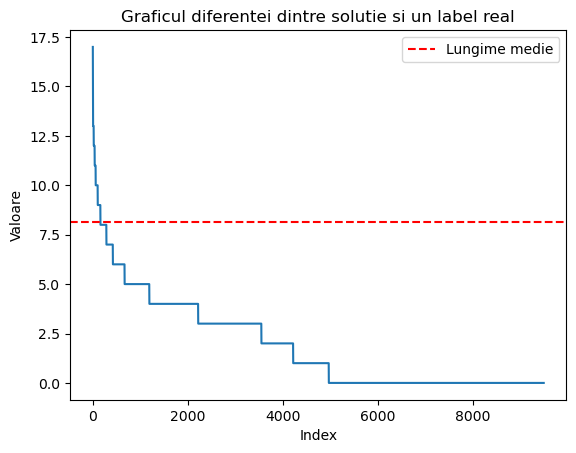

In [124]:
plt.plot(sorted(differences, reverse=True))
plt.title("Graficul diferentei dintre solutie si un label real")
plt.axhline(y=medium_lengh_word_label, color='r', linestyle='--', label='Lungime medie')
plt.xlabel("Index")
plt.ylabel("Valoare")
plt.legend()
plt.show()

In this graph, we display the ratio between probability and the degree of matching, and we observe that those with a higher matching tend to have a higher probability as well.

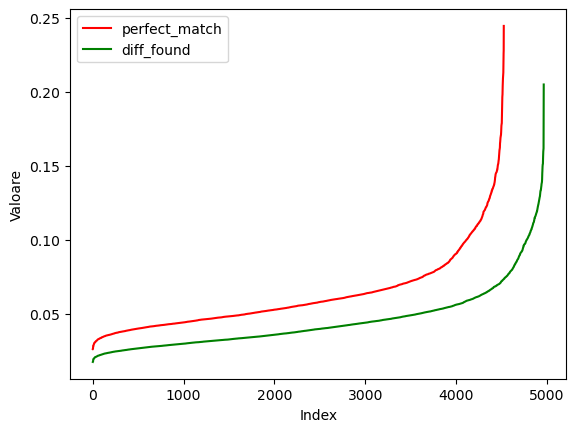

In [120]:
max_prob = [np.max(final_probabilities[i]) for i in range(len(final_probabilities))]
top_indices = [np.argmax(final_probabilities[i]) for i in range(len(final_probabilities))]
differences = [check_difference(data_words[i], label_words[top_indices[i]]) for i in range(len(data_words))]

plt.plot(sorted([x for x,y in zip(list(max_prob), differences) if y == 0]), color='red', label='perfect_match')
plt.plot(sorted([x for x,y in zip(list(max_prob), differences) if y > 0]), color='green', label='diff_found')
plt.xlabel("Index")
plt.ylabel("Valoare")
plt.legend()
plt.show()

The last graph is a heatmap obtained from probabilities.

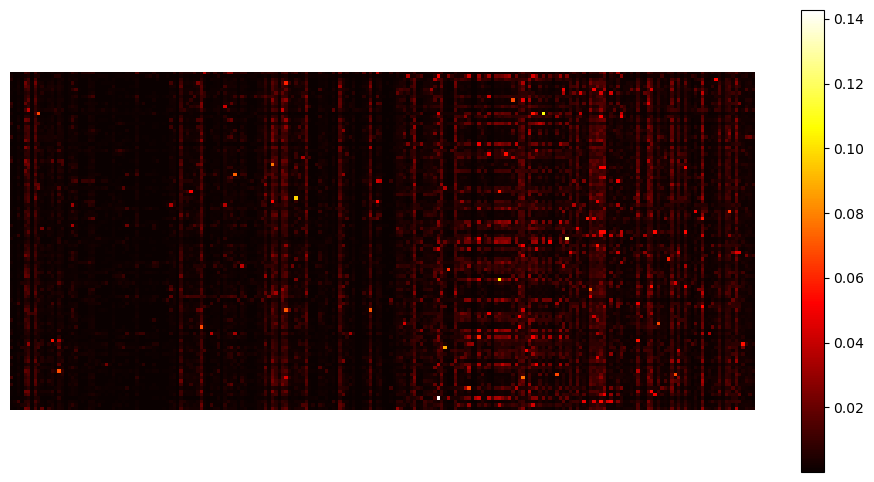

In [121]:
show_matrix = final_probabilities[:100] 
plt.figure(figsize=(12, 12))
img = plt.imshow(show_matrix, cmap='hot', interpolation='nearest')
bar = plt.colorbar(img, shrink=0.5)
plt.axis('off')
plt.show()

In [122]:
data_result = data.copy(deep=True)
data_result["insurance_label"] = ""
for index, results in enumerate(final_probabilities):
    answers = [labels.loc[i, "label"] for i in np.where(abs(results - np.max(results)) < 1e-8)[0]]
    data_result.at[index, "insurance_label"] = str("[" + ", ".join(answers) + "]")

In [123]:
data_result.to_csv('results.csv', index=False)